# Os discursos da CPI da Pandemia: Palavras mais Frequentes

## Módulos e Coleta de Dados

In [2]:
## Módulos
# Manipulação e Coleta de Dados 
import pandas as pd
import numpy as np
import basedosdados as bd

# Gráficos e limpagem de células
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Análises
from wordcloud import WordCloud, ImageColorGenerator
import nltk
import operator

In [3]:
## Baixando módulos de processamento de linguagem natural
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
clear_output()

In [4]:
## Coletando os dados individuais de vacinação
# ID do projeto no Google Cloud
sProjectID = "pnadc-316222"

## Lendo dados
df = bd.read_table(dataset_id='br_senado_cpipandemia', 
                   table_id='discursos',
                   billing_project_id=sProjectID)

## Vendo resultado
df.head()

Downloading: 100%|██████████| 54913/54913 [00:45<00:00, 1210.25rows/s]


,sequencial_sessao,data_sessao,sigla_partido,sigla_uf_partido,bloco_parlamentar,nome_discursante,genero_discursante,categoria_discursante,texto_discurso,horario_inicio_discurso,...,duracao_discurso,sinalizacao_pela_ordem,sinalizacao_questao_ordem,sinalizacao_fora_microfone,sinalizacao_responder_questao_ordem,sinalizacao_por_videoconferencia,sinalizacao_para_interpelar,sinalizacao_para_expor,sinalizacao_para_depor,sinalizacao_como_presidente
0,01,2021-04-27,PSD,BA,NA,OTTO ALENCAR,Masculino,Senador/a,"Invocando a proteção de Deus, declaro aberta a...",10:00:00,...,0.0,Não,Não,Não,Não,Não,Não,Não,Não,Sim
1,01,2021-04-27,PP,PI,Bloco Parlamentar Unidos pelo Brasil,CIRO NOGUEIRA,Masculino,Senador/a,"Sr. Presidente, Sras. e Srs. Senadores, eu ach...",10:00:00,...,240.0,Não,Sim,Não,Não,Não,Não,Não,Não,Não
2,01,2021-04-27,PSD,BA,NA,OTTO ALENCAR,Masculino,Senador/a,"Senador Ciro Nogueira, esta é uma Comissão Par...",10:04:00,...,0.0,Não,Não,Não,Não,Não,Não,Não,Não,Sim
3,01,2021-04-27,PP,PI,Bloco Parlamentar Unidos pelo Brasil,CIRO NOGUEIRA,Masculino,Senador/a,"Sr. Presidente, não é o caso de indeferir ou n...",10:04:00,...,0.0,Não,Não,Não,Não,Não,Não,Não,Não,Não
4,01,2021-04-27,PSD,BA,NA,OTTO ALENCAR,Masculino,Senador/a,Eu indeferi. Sou Presidente e posso indeferir.,10:04:00,...,0.0,Não,Não,Não,Não,Não,Não,Não,Não,Sim


## Manipulação dos Dados

### Limpeza

In [5]:
## Removendo pontuações usando expressões regulares
# [ começo
# ^ negação
# \w palabras, \s espaços
# ] fim
# 'remova tudo que não for uma letra ou espaço'
df["texto_discurso"] = df['texto_discurso'].str.replace('[^\w\s]','')

In [6]:
## Vamos remover tudo que tem menos de três letras
df["texto_discurso"] = df['texto_discurso'].str.replace(r'\b(\w{1,3})\b','')

In [7]:
## Tirando números
df["texto_discurso"] = df['texto_discurso'].str.replace(r'\d+','')

In [8]:
## Coletando a coluna relevante
vDiscursos = df.texto_discurso

In [9]:
## Tokenizando
df['token_discurso'] = vDiscursos.apply(nltk.tokenize.word_tokenize)

## Vendo resultado
df.token_discurso

0        [Invocando, proteção, Deus, declaro, aberta, s...
1        [Presidente, Sras, Senadores, achava, deveríam...
2        [Senador, Ciro, Nogueira, esta, Comissão, Parl...
3                [Presidente, caso, indeferir, Isso, aqui]
4                 [indeferi, Presidente, posso, indeferir]
                               ...                        
54908                                  [Obrigado, Senador]
54909    [esta, oitiva, agradecer, você, contribuição, ...
54910    [Senador, advogado, agradecemos, chegamos, aqu...
54911    [agradeço, agradecemos, Cristiano, tratamento,...
54912    [queria, desejar, mais, pronto, restabelecimen...
Name: token_discurso, Length: 54913, dtype: object

In [10]:
## Deixando tudo minúsculo
# Por haver uma empresa chamada Precisa Medicamentos, vamos deixar "Precisa" como ela aparece no texto
df['token_discurso'] = df['token_discurso'].apply(lambda x: [palavra.lower() for palavra in x if palavra not in ["Precisa"]])

### StopWords e Processamento de Linguagem Natural

In [11]:
## Vamos remover as 'stopwords' (preposições e afins)
# Pegando lista e contando o númeero de palavras
lStopWords = nltk.corpus.stopwords.words('portuguese')
len(lStopWords)

204

In [12]:
## Tirando stopwords
df['token_discurso'] = df['token_discurso'].apply(lambda x: [palavra for palavra in x if palavra not in lStopWords])

# Vendo resultado
df['token_discurso']

0        [invocando, proteção, deus, declaro, aberta, s...
1        [presidente, sras, senadores, achava, deveríam...
2        [senador, ciro, nogueira, comissão, parlamenta...
3                      [presidente, caso, indeferir, aqui]
4                 [indeferi, presidente, posso, indeferir]
                               ...                        
54908                                  [obrigado, senador]
54909    [oitiva, agradecer, contribuição, trouxe, info...
54910    [senador, advogado, agradecemos, chegamos, aqu...
54911    [agradeço, agradecemos, cristiano, tratamento,...
54912    [queria, desejar, pronto, restabelecimento, se...
Name: token_discurso, Length: 54913, dtype: object

In [13]:
## Colapsando as palavras de todos os discursos em uma só lista
vTokens = np.concatenate(df.token_discurso.values, axis=0)
vTokens

array(['invocando', 'proteção', 'deus', ..., 'encerrada', 'horas',
       'minutos'], dtype='<U32')

In [14]:
## Número total de palavras
len(vTokens)

863398

In [15]:
## Calculando distribuição das palavras
dictDist = dict(nltk.FreqDist(list(vTokens)))

In [16]:
## Vendo as mais faladas
sorted(dictDist.items(),key=operator.itemgetter(1),reverse=True)

[('aqui', 11106),
 ('presidente', 10816),
 ('senador', 10668),
 ('senhor', 9483),
 ('então', 7440),
 ('porque', 7183),
 ('saúde', 5832),
 ('gente', 5726),
 ('ministério', 4693),
 ('fazer', 3943),
 ('vacina', 3830),
 ('brasil', 3748),
 ('governo', 3524),
 ('ministro', 3408),
 ('sobre', 3390),
 ('senhora', 3033),
 ('pessoas', 2985),
 ('pode', 2965),
 ('agora', 2891),
 ('todos', 2873),
 ('relação', 2718),
 ('momento', 2634),
 ('federal', 2595),
 ('dizer', 2499),
 ('questão', 2453),
 ('pandemia', 2364),
 ('pergunta', 2271),
 ('vacinas', 2259),
 ('acho', 2157),
 ('hoje', 2156),
 ('comissão', 2148),
 ('quero', 2100),
 ('queria', 2098),
 ('milhões', 2090),
 ('disse', 2087),
 ('vamos', 2064),
 ('favor', 2030),
 ('estado', 2002),
 ('contrato', 1995),
 ('inclusive', 1987),
 ('covid', 1939),
 ('ainda', 1908),
 ('tempo', 1875),
 ('coisa', 1842),
 ('forma', 1812),
 ('obrigado', 1789),
 ('falar', 1729),
 ('república', 1728),
 ('todo', 1694),
 ('verdade', 1660),
 ('senadora', 1606),
 ('assim', 1595),

In [17]:
## Retirando algumas outras palavras não captadas pelos stopwords ou pelos
## outros filtros anteriores
# Lista
lPalavras = ['sras', 'para', 'isso', 'aqui', 'caso', 'presidente', 
             'senador', 'senadora', 'senadores', 'pelo', 'pela',
             'este', 'esta', 'está', 'esse', 'essa', 'indeferir', 'deferir'
             'indeferi', 'deferi', 'indeferido', 'deferido', 'senhor',
             'gente', 'porque', 'senhora', 'pode', 'aberta', 'abertura',
             'disso', 'além', 'comissão', 'parlamentar', 'desta', 'inquérito',
             'todos', 'todas', 'queria', 'desta', 'deste', 'sessão', 'parte',
             'agradeço', 'agradecemos', 'agradecer', 'posso', 'aqui', 'então',
             'fazer', 'sobre', 'agora', 'dizer', 'relação', 'hoje', 'forma', 'coisa',
             'momento', 'federal', 'acho', 'quero', 'milhões', 'disse', 'vamos', 'favor',
             'ainda', 'pergunta', 'questão', 'inclusive', 'ainda', 'tempo', 'falar', 'obrigado',
             'todo', 'assim', 'república', 'precisa', 'sendo', 'sabe', 'nesse', 'tudo', 'claro',
             'relator', 'importante', 'qualquer', 'dessa', 'outros', 'dias', 'ordem', 'nenhum',
             'algum', 'alguma', 'fala', 'falou', 'primeiro', 'mundo', 'país', 'contra', 'grande',
             'nada', 'nunca', 'falando', 'outra', 'primeira', 'dois', 'quer', 'desse', 'nenhuma',
             'feito', 'apenas', 'algum', 'microfone', 'outro', 'onde', 'antes', 'sempre', 'vezes',
             'dizendo', 'deputado', 'trabalho', 'informações', 'exatamente', 'sido',
             'pois', 'dentro', 'havia', 'fazendo', 'número', 'outras', 'seguinte', 'poderia',
             'responder', 'maior', 'perguntas', 'perfeito', 'toda', 'processo', 'palavra', 'nacional',
             'saber', 'brasileiro', 'nessa', 'pouco', 'poder', 'países', 'país', 'duas', 'quanto', 'ninguém',
             'alguns', 'tipo', 'existe', 'minutos', 'pública', 'brasileira', 'estar', 'desde',
             'janeiro', 'depoente', 'três', 'menos', 'gostaria', 'realmente', 'alguém',
             'neste', 'aconteeceu', 'cada', 'final', 'olha', 'algumas', 'casa', 'nesta', 'ponto',
             'anos', 'excelência', 'ontem', 'veja', 'excelência', 'portanto', 'segundo', 'pedir', 'mesma',
             'possível', 'deve', 'falta', 'melhor', 'falei', 'possa', 'sentido', 'tanto', 'colocar',
             'chegou', 'peço', 'durante', 'passar', 'pergunto', 'coisas', 'feita', 'minutinho', 'naquele',
             'muitas', 'vários', 'ouvir', 'partir', 'certo', 'desses', 'ficar', 'senhores', 'diante', 'casos',
             'quais', 'certeza', 'aconteceu', 'deixar', 'acredito', 'faço', 'dessas', 'muitos', 'várias']

## Retirando as palavras
df["token_discurso"] = df['token_discurso'].apply(lambda x: [palavra for palavra in x if palavra not in lPalavras])

## Resultado
df["token_discurso"]

0        [invocando, proteção, deus, declaro, eleição, ...
1        [achava, deveríamos, suspender, atual, sanado,...
2        [ciro, nogueira, temática, investigar, acordo,...
3                                                       []
4                                               [indeferi]
                               ...                        
54908                                                   []
54909    [oitiva, contribuição, trouxe, trouxe, alarman...
54910    [advogado, chegamos, manhã, aliás, encontrar, ...
54911    [cristiano, tratamento, firmeza, necessária, t...
54912    [desejar, pronto, restabelecimento, otto, alen...
Name: token_discurso, Length: 54913, dtype: object

In [18]:
## Colapsando todos os discursos em uma só lista
vTokens = np.concatenate(df.token_discurso.values, axis=0)

## Substituindo alguns sinônimos
# Idealmente, faríamos isso usando lematização, mas não encontrei
# nenhuma biblioteca que faz isso bem para português (nem nltk, nem stanza)
# No stanza, por exemplo, vacina/vacinação tinham lemas diferentes; no nltk, não há suporte para português
if True:  # para permitir colapsar no PyCharm
    vTokens = np.where(
        (vTokens == "vacinação") | (vTokens == "vacinas"),
        "vacina",
        vTokens
    )
    vTokens = np.where(
        (vTokens == "médico") | (vTokens == "médicos"),
        "médico",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "pessoa") | (vTokens == "pessoas"),
        "pessoas",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "amazonas") | (vTokens == "manaus"),
        "amazonas",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "vírus") | (vTokens == "doença"),
        "covid",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "estudo") | (vTokens == "estudos"),
        "estudos",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "dose") | (vTokens == "doses"),
        "doses",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "paciente") | (vTokens == "pacientes"),
        "pacientes",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "recurso") | (vTokens == "recursos"),
        "recursos",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "fatos") | (vTokens == "fato"),
        "fato",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "requerimento") | (vTokens == "requerimentos"),
        "requerimento",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "medida") | (vTokens == "medidas"),
        "medidas",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "vida") | (vTokens == "vidas"),
        "vidas",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "morte") | (vTokens == "mortes"),
        "mortes",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "cloroquina") | (vTokens == "hidroxicloroquina"),
        "cloroquina",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "ação") | (vTokens == "ações"),
        "ações",
        vTokens
    )

    vTokens = np.where(
        (vTokens == "posição") | (vTokens == "posições"),
        "posições",
        vTokens
    )

In [19]:
## Calculando distribuição das palavras e pegando as 100 mais frequentes
dictDist = dict(nltk.FreqDist(list(vTokens)))
dictDist = dict(sorted(dictDist.items(),key=operator.itemgetter(1),reverse=True)[:100])

# Vendo resultado
dictDist

{'vacina': 6824,
 'saúde': 5832,
 'ministério': 4693,
 'pessoas': 3966,
 'brasil': 3748,
 'covid': 3545,
 'governo': 3524,
 'ministro': 3408,
 'pandemia': 2364,
 'estado': 2002,
 'doses': 2002,
 'contrato': 1995,
 'amazonas': 1744,
 'médico': 1738,
 'verdade': 1660,
 'fato': 1641,
 'cloroquina': 1601,
 'reunião': 1482,
 'empresa': 1456,
 'estados': 1436,
 'tratamento': 1416,
 'estudos': 1408,
 'medidas': 1364,
 'população': 1360,
 'requerimento': 1322,
 'vidas': 1308,
 'pfizer': 1297,
 'informação': 1267,
 'exemplo': 1260,
 'anvisa': 1102,
 'renan': 1101,
 'pacientes': 1025,
 'conhecimento': 998,
 'respeito': 980,
 'ciência': 972,
 'decisão': 969,
 'mortes': 957,
 'nome': 922,
 'brasileiros': 917,
 'ações': 906,
 'rogério': 900,
 'marcos': 899,
 'público': 888,
 'recursos': 866,
 'intervenção': 852,
 'problema': 851,
 'medicamentos': 828,
 'governador': 825,
 'eduardo': 785,
 'resposta': 770,
 'política': 761,
 'municípios': 751,
 'situação': 742,
 'documento': 738,
 'sistema': 713,
 '

## WordCloud

In [20]:
## Importando módulos para desenhar o Wordcloud com base na bandeira do Brasil
from PIL import Image
import random

In [21]:
## Função para desenhar o WordCloud com base em um dicionário de frequêncas
def desenhar_wordcloud(dictFrequencias, bGray=False, bSalvar=True):
    # Lendo a bandeira do Brasil
    # Importante: tem que ter alta resolução!
    maskBrasil = np.array(Image.open("brasil.jpeg"))

    # Função para pintar as palavras numa paleta de cinza
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

    ## Gerando a WordCloud
    wc = WordCloud(background_color="white", max_words=100, mask=maskBrasil, width=1000, height=2000)
    wc.generate_from_frequencies(dictFrequencias)

    ## Pintando na paleta cinza (se solicitado)
    if bGray:
        wc.recolor(color_func=grey_color_func, random_state=3)

    ## Exibindo o resultado e salvando (se solicitado)
    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if bSalvar:
        plt.savefig("WordCloud_CPI.png", figsize=(20, 10), dpi=1200)
    plt.show()

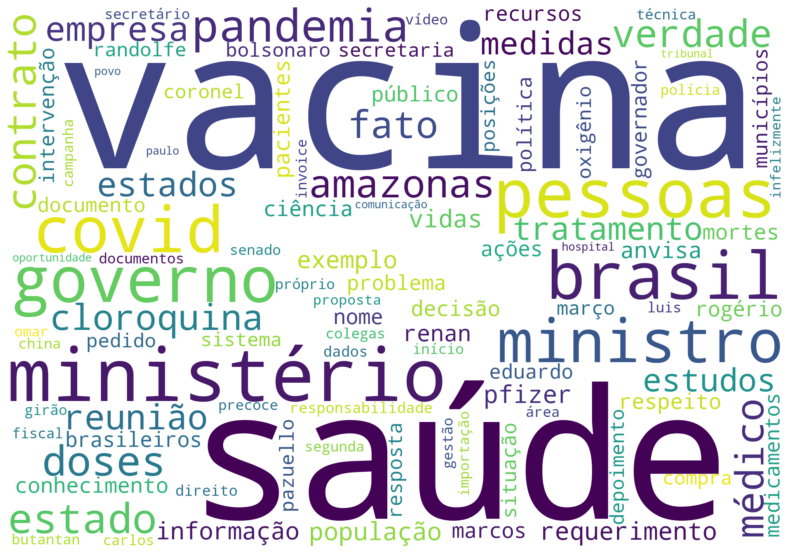

In [22]:
## Chamando a função que desenha o word cloud
desenhar_wordcloud(dictDist, bSalvar=False)

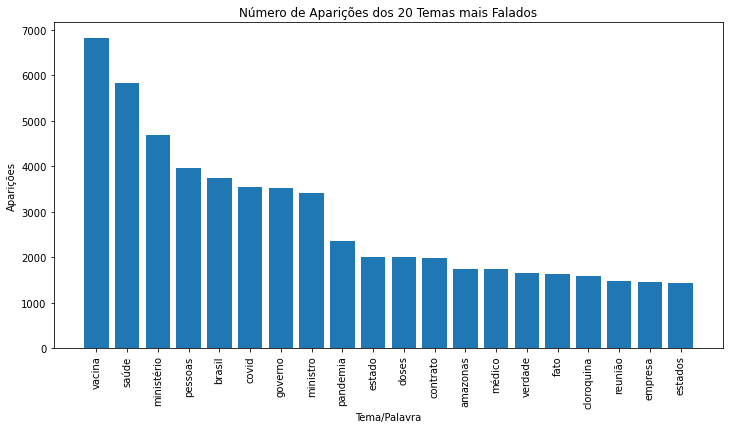

In [23]:
## Fazendo um gráfico de barra simples para ver a distribuição das 20 palavras mais ditas
# Pegando 20 primeiros valores
dictGrafico = {k: dictDist[k] for k in list(dictDist)[:20]}
lChaves = dictGrafico.keys()
lAparicoes = dictGrafico.values()

# Plottando
# Objeto gráfico
fig = plt.figure(figsize=(12, 6))
# Barras
plt.bar(lChaves, lAparicoes)
# Títulos
plt.title("Número de Aparições dos 20 Temas mais Falados")
plt.ylabel("Aparições")
plt.xlabel("Tema/Palavra")
# Rotação
plt.xticks(rotation=90)

# Salvando
plt.savefig("Palavras_CPI.png", figsize=(12, 6), dpi=1200)